In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib inline
import gc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dữ liệu
bureau = pd.read_csv('/content/drive/My Drive/group6_Final_DP/data/raw_data/bureau.csv')
bureau_balance = pd.read_csv('/content/drive/My Drive/group6_Final_DP/data/raw_data/bureau_balance.csv')

Bureau duplicated rows: 0
Bureau Balance duplicated rows: 0
Missing values in Bureau:
 DAYS_ENDDATE_FACT       37.170798
AMT_CREDIT_SUM           0.000205
AMT_CREDIT_SUM_DEBT     15.224882
AMT_CREDIT_SUM_LIMIT    33.417160
AMT_ANNUITY             77.116885
dtype: float64
Missing values in Bureau Balance:
 Series([], dtype: float64)


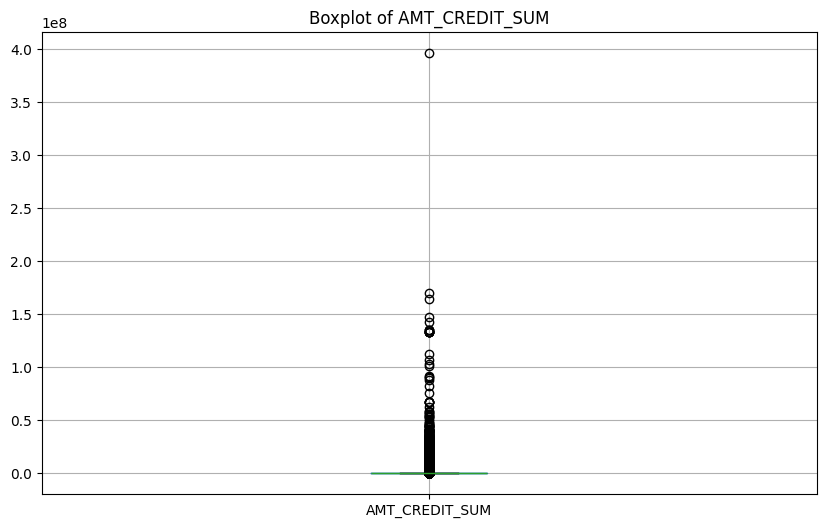

<ipython-input-6-04c54f2e7115>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bureau[numerical_columns] = scaler.fit_transform(bureau[numerical_columns])


Data processing complete. Final dataset shape: (262712, 34)


In [ ]:

# STEP 1: KIỂM TRA DỮ LIỆU TRÙNG LẶP
print("Bureau duplicated rows:", bureau.duplicated().sum())  # Kiểm tra trùng lặp
bureau = bureau.drop_duplicates()  # Loại bỏ trùng lặp

print("Bureau Balance duplicated rows:", bureau_balance.duplicated().sum())
bureau_balance = bureau_balance.drop_duplicates()

# STEP 2: KIỂM TRA VÀ PHÂN TÍCH GIÁ TRỊ THIẾU
missing_bureau = bureau.isnull().sum() / len(bureau) * 100
missing_bureau_balance = bureau_balance.isnull().sum() / len(bureau_balance) * 100

print("Missing values in Bureau:\n", missing_bureau[missing_bureau > 0])
print("Missing values in Bureau Balance:\n", missing_bureau_balance[missing_bureau_balance > 0])

# Quyết định điền giá trị thiếu (fillna)
bureau['DAYS_CREDIT_ENDDATE'] = bureau['DAYS_CREDIT_ENDDATE'].fillna(0)
bureau['AMT_CREDIT_MAX_OVERDUE'] = bureau['AMT_CREDIT_MAX_OVERDUE'].fillna(0)


# STEP 3: PHÁT HIỆN VÀ LOẠI BỎ NGOẠI LỆ
# Vẽ boxplot để kiểm tra ngoại lệ
plt.figure(figsize=(10, 6))
bureau.boxplot(column=['AMT_CREDIT_SUM'])
plt.title('Boxplot of AMT_CREDIT_SUM')
plt.show()

# Loại bỏ ngoại lệ dựa trên percentile (1% và 99%)
lower_bound = bureau['AMT_CREDIT_SUM'].quantile(0.01)
upper_bound = bureau['AMT_CREDIT_SUM'].quantile(0.99)
bureau = bureau[(bureau['AMT_CREDIT_SUM'] >= lower_bound) & (bureau['AMT_CREDIT_SUM'] <= upper_bound)]

# STEP 4: CHUẨN HÓA DỮ LIỆU SỐ
# Chuẩn hóa các cột số
scaler = MinMaxScaler()
numerical_columns = ['AMT_CREDIT_SUM', 'AMT_ANNUITY', 'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE']
bureau[numerical_columns] = scaler.fit_transform(bureau[numerical_columns])

# STEP 5: XỬ LÝ DỮ LIỆU PHÂN LOẠI
# Mã hóa cột phân loại trong Bureau Balance
bureau_balance['STATUS_mod'] = bureau_balance['STATUS'].map({'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, 'X': np.nan, 'C': 0}).interpolate(method='linear')
bureau_balance['write_off'] = bureau_balance['STATUS'].map(lambda x: 1 if x == '5' else 0)

# One-hot encoding cho các cột phân loại trong Bureau
bureau_cat = pd.get_dummies(bureau[['SK_ID_CURR', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']], prefix='bur')
bureau_cat_feature = bureau_cat.groupby('SK_ID_CURR').mean().reset_index()


# STEP 6: TẠO FEATURE MỚI (FEATURE ENGINEERING)
# Bureau Balance Aggregation
bb_month_count = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].count()
bb_dpd_sum = bureau_balance.groupby('SK_ID_BUREAU')['STATUS_mod'].sum()
bb_write_off = bureau_balance.groupby('SK_ID_BUREAU')['write_off'].sum()

bb_feature = pd.DataFrame({
    'bb_month_count': bb_month_count,
    'bb_dpd_sum': bb_dpd_sum,
    'bb_write_off': bb_write_off
}).reset_index().fillna(0)

# Bureau Aggregation
bur_ncount = bureau.groupby('SK_ID_CURR')['SK_ID_BUREAU'].count()
bur_act_count = bureau.loc[bureau.CREDIT_ACTIVE == 'Active'].groupby('SK_ID_CURR')['SK_ID_BUREAU'].count().fillna(0)
bur_bad_count = bureau.loc[bureau.CREDIT_ACTIVE == 'Bad debt'].groupby('SK_ID_CURR')['SK_ID_BUREAU'].count().fillna(0)

# Application intervals and overdue statistics
bureau['application_interval'] = bureau.groupby('SK_ID_CURR')['DAYS_CREDIT'].diff(-1).fillna(0)
bur_avg_interval = bureau.groupby('SK_ID_CURR')['application_interval'].mean()
bur_sd_interval = bureau.groupby('SK_ID_CURR')['application_interval'].std().fillna(0)

# Aggregate features for overdue and credit amounts
bur_max_overdue = bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].max()
bur_total_debt = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum().fillna(0)
bur_avg_annuity = bureau.groupby('SK_ID_CURR')['AMT_ANNUITY'].mean().fillna(0)

# Combine Bureau Balance with Bureau features
bureau_bb = bureau[['SK_ID_CURR', 'SK_ID_BUREAU']].merge(bb_feature, on='SK_ID_BUREAU', how='left')

bb_avg_month = bureau_bb.groupby('SK_ID_CURR')['bb_month_count'].mean().fillna(0)
bb_total_overdue = bureau_bb.groupby('SK_ID_CURR')['bb_dpd_sum'].sum().fillna(0)
bb_total_write_off = bureau_bb.groupby('SK_ID_CURR')['bb_write_off'].sum().fillna(0)

# Combine all features into a single DataFrame
bureau_feature = pd.DataFrame({
    'bur_ncount': bur_ncount,
    'bur_act_count': bur_act_count,
    'bur_bad_count': bur_bad_count,
    'bur_avg_interval': bur_avg_interval,
    'bur_sd_interval': bur_sd_interval,
    'bur_max_overdue': bur_max_overdue,
    'bur_total_debt': bur_total_debt,
    'bur_avg_annuity': bur_avg_annuity,
    'bb_avg_month': bb_avg_month,
    'bb_total_overdue': bb_total_overdue,
    'bb_total_write_off': bb_total_write_off
}).reset_index()

# Merge with categorical features
bureau_feature = bureau_feature.merge(bureau_cat_feature, on='SK_ID_CURR', how='left')

# STEP 7: LƯU DỮ LIỆU SAU XỬ LÝ
bureau_feature.to_csv('/content/drive/My Drive/group6_Final_DP/data/processed_data/bureau_feature.csv', index=False)

print("Data processing complete. Final dataset shape:", bureau_feature.shape)

